In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import DivergingNorm
import sys
sys.path.insert(1, '../../utils/')
import src_utils
import seaborn as sns

# 1. Read in all necessary data

In [109]:
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rcParams['axes.linewidth'] = 0.5

plt.rcParams["figure.dpi"] = 300

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title

In [110]:
"""
Necessary data:
 - All residual values
 - Client masks
"""

# All residual values
resid_map = pd.read_csv('../heatmaps/raw_resid_heatmap.csv', index_col=0)

# Client masks
client_mask = np.loadtxt('../../utils/analysis_utils/client_mask.csv').astype(bool)
strong_client_mask = np.loadtxt('../../utils/analysis_utils/strong_client_mask.csv').astype(bool)
ihb_client_mask = np.loadtxt('../../utils/analysis_utils/inhibited_clients.csv').astype(bool)
dep_client_mask = np.loadtxt('../../utils/analysis_utils/dependent_clients.csv').astype(bool)

## Figure 3a: Windowed average of mean residual score by position

[(0.4044212904941176, 0.5346434904470588, 0.9320019126352941),
 (0.603162067917647, 0.7315274773529412, 0.9995652785372549),
 (0.7867207013568628, 0.8448072103686275, 0.9398103849490196),
 (0.9306685963333333, 0.818876999654902, 0.7591463906980392),
 (0.9673165156666667, 0.6574708288078431, 0.5381601507294118),
 (0.8846434386941177, 0.41001709788235297, 0.32250654924705885)]

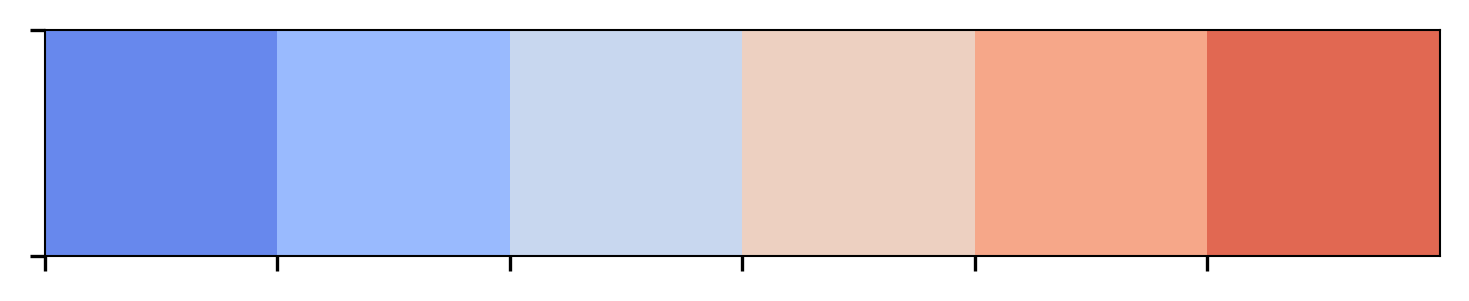

In [111]:
num_shades = 8
palette = sns.color_palette('coolwarm')
sns.palplot(palette)
palette

In [112]:
def moving_average(a, n=10) :
    ret = np.nancumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

pos_resid_ave = resid_map.mean(axis=1, skipna=True).values
windowed_resids = moving_average(pos_resid_ave)

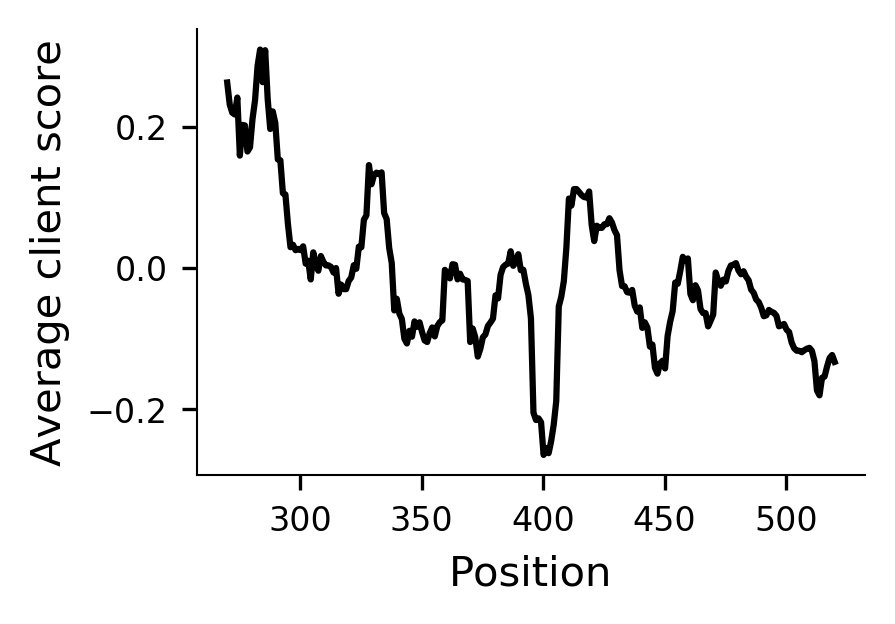

In [152]:
width = 73. / 25.4
height = 50. / 25.4
fig, ax = plt.subplots(figsize=(width, height), dpi=300)
#plt.figure(figsize=(width, height), dpi=300)
plt.plot(np.linspace(270, 520, num=len(windowed_resids)), windowed_resids, c='k')
plt.ylabel('Average client score')
plt.xlabel('Position')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#plt.title('Average client score by position')

## Figure 3b. Number of clients per position

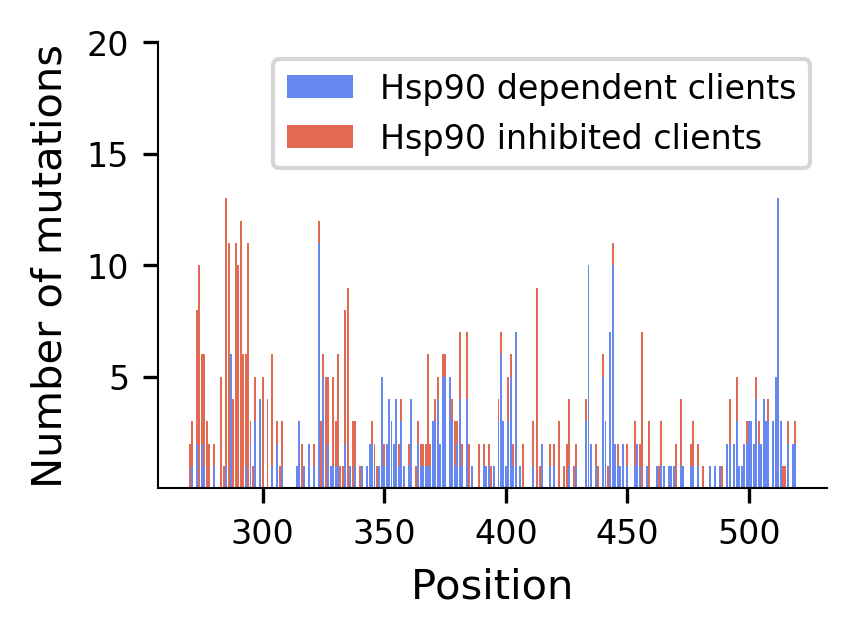

In [153]:
width = 73. / 25.4
height = 50. / 25.4
#plt.figure(figsize=(width, height), dpi=300)
fig, ax = plt.subplots(figsize=(width, height), dpi=300)
pos_arr = np.arange(270, 520)
#plt.bar(pos_arr, num_mut, color='k')
plt.bar(pos_arr, num_dep, color=palette[0], label='Hsp90 dependent clients')
plt.bar(pos_arr, num_ihb, color=palette[-1], bottom=num_dep, label='Hsp90 inhibited clients')
plt.yticks([5,10,15,20])
plt.xlabel('Position')
plt.ylabel('Number of mutations')
plt.legend()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#plt.title('Clients by position')

## Figure 3E. PyMOL figures

In [122]:
# Calculate average client score and average client sensitivity by position
pos_client_sens = abs(resid_map).mean(axis=1).values

# Replace NaNs with zeroes
pos_resid_ave_fill = np.nan_to_num(pos_resid_ave, nan=0.0)
pos_client_sens_fill = np.nan_to_num(pos_client_sens, nan=0.0)

# Save
np.savetxt('../../PyMOL/client_scores.txt', pos_resid_ave_fill, delimiter='\n')
np.savetxt('../../PyMOL/client_sens.txt', pos_client_sens_fill, delimiter='\n')

In [126]:
# Get min max val
max(abs(pos_resid_ave))

1.3205864844522963

## Figure 3C and 3D: amino acid comparison of non client and client, inhibited and dependent clients

In [239]:
# Types of mutants in clients
client_muts = np.sum(client_mask, axis=0)
nonclient_muts = np.sum(~client_mask, axis=0)
client_med_aa = np.nanmedian(resid_map.values, axis=0)
total_muts = np.sum(~np.isnan(resid_map.values), axis=0)

# Percent clients
perc_client = client_muts / total_muts

# Dictionary for ticks
inv_aa_idx_dict = inv_map = {v: k for k, v in src_utils.__aa_idx_dict__.items()}

# Calculate median and mean
med_num_client = np.median(client_muts)
med_client_score = np.nanmedian(client_med_aa)
med_perc = np.nanmedian(perc_client)

In [238]:
nonclient_muts

array([220, 221, 215, 223, 227, 213, 212, 209, 226, 215, 217, 218, 211,
       219, 221, 221, 224, 207, 215, 227, 244])

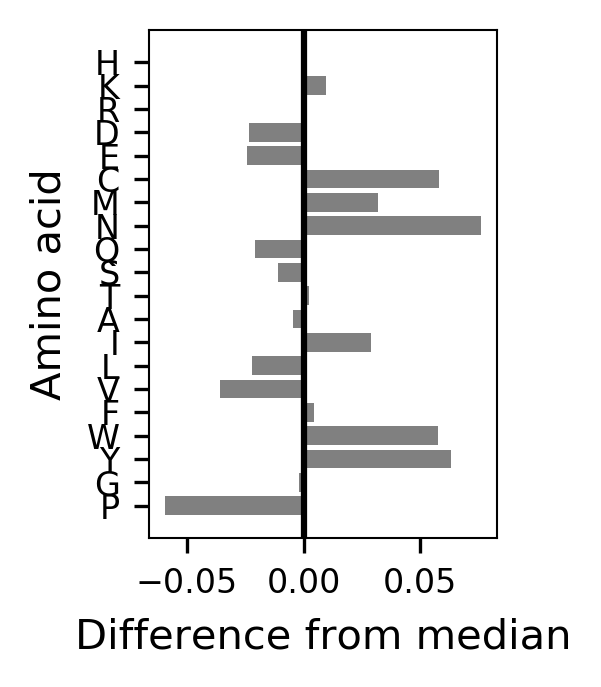

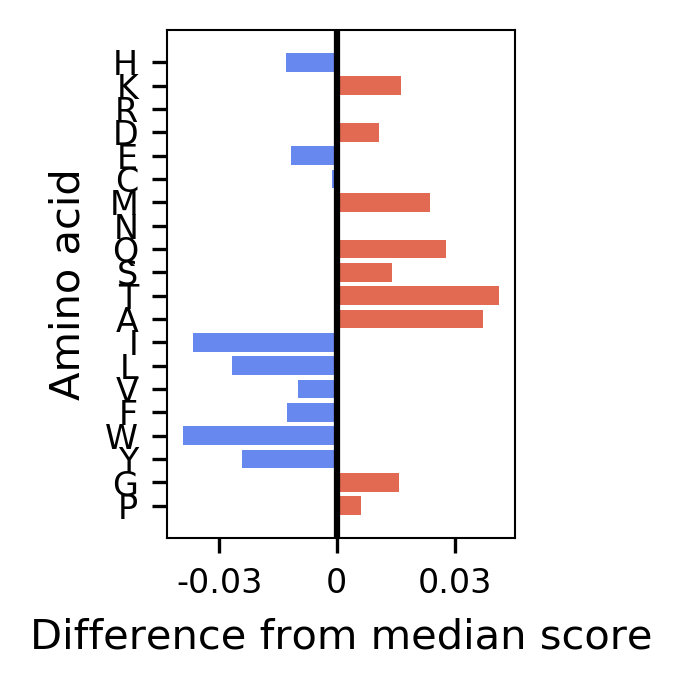

In [241]:
# Set figure dimensions
width = 38 / 25.4
height = 57 / 25.4
fig, ax = plt.subplots(figsize=(width, height), dpi=300)

# Set tick labels and locations
y_pos = list(inv_aa_idx_dict.keys())
tick_labels = inv_aa_idx_dict.values()

# Plot bars
ax.barh(y_pos[:-1], perc_client[:-1] - med_perc, align='center', label='Clients', color='gray')
ax.axvline(0, c='k')

# Relabel ticks
ax.set_yticks(y_pos[:-1])
ax.set_yticklabels(list(tick_labels)[:-1])
ax.invert_yaxis()  # labels read top-to-bottom

# Label axes
ax.set_xlabel('Difference from median')
ax.set_ylabel('Amino acid')

# Show figure
plt.show()


# Median effect scores
fig, ax = plt.subplots(figsize=(width, height), dpi=300)

# Set tick labels and locations
y_pos = list(inv_aa_idx_dict.keys())
tick_labels = inv_aa_idx_dict.values()

# Set color
color_bars = []
for val in client_med_aa[:-1] - med_client_score:
    if val > 0:
        color_bars.append(palette[-1])
    else:
        color_bars.append(palette[0])
# Plot bars
ax.barh(y_pos[:-1], client_med_aa[:-1] - med_client_score, align='center', label='Clients', color=color_bars)
ax.axvline(0, c='k')

# Relabel ticks
ax.set_yticks(y_pos[:-1])
ax.set_yticklabels(list(tick_labels)[:-1])
ax.set_xticks([-0.03, 0, 0.03])
ax.set_xticklabels([-0.03, 0, 0.03])
ax.invert_yaxis()  # labels read top-to-bottom

# Label axes
ax.set_xlabel('Difference from median score')
ax.set_ylabel('Amino acid')

# Show figure
plt.show()

In [185]:
# Numbers of clients
ihb_clients_by_mut = np.sum(ihb_client_mask, axis=0)
dep_clients_by_mut = np.sum(dep_client_mask, axis=0)

ihb_diff = ihb_clients_by_mut - med_num_client
dep_diff = dep_clients_by_mut - med_num_client

diff_diff = ihb_diff - dep_diff

# Differences in effect score


In [192]:
color_bars = []
for val in diff_diff:
    if val > 0:
        color_bars.append(palette[-1])
    else:
        color_bars.append(palette[0])

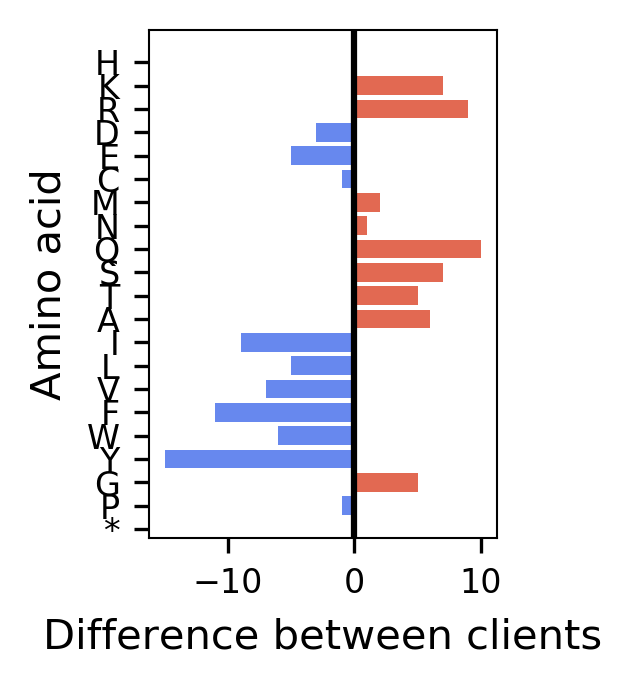

In [195]:
width = 38 / 25.4
height = (57 / 25.4)
fig, ax = plt.subplots(figsize=(width, height), dpi=300)

# Set tick labels and locations
y_pos = list(inv_aa_idx_dict.keys())
tick_labels = inv_aa_idx_dict.values()


#ax.barh(y_pos, total_muts, align='center', label='Total mutants')
ax.barh(y_pos[:-1], diff_diff[:-1], align='center', label='Clients', color=color_bars)
#ax.barh(y_pos[:-1], ihb_clients_by_mut[:-1], align='center', label='Clients', color=palette[-1])

ax.axvline(0, c='k')
ax.set_yticks(y_pos)
ax.set_yticklabels(tick_labels)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Difference between clients')
ax.set_ylabel('Amino acid')
#ax.set_title('Amino acid mutants in clients')
#plt.legend(bbox_to_anchor=(1.05, 1.0))
plt.show()
#fig.savefig("output.png")